在这一小节你将学到：
1. 多层感知机MLP是什么
2. MLP的隐藏层hidden layer是什么，什么是激活函数
- 隐藏层位于输入层和输出层之间，不直接与外界交互，是使用激活函数的地方
- 激活函数是引入非线性能力的函数，有了激活函数 → 网络可以近似任何函数（万能逼近定理）

3. 如何训练一个多层感知机(简单实例)
- 前向传播Forward是什么
- 损失函数/代价函数 LossFunction (Cost Function)
- backward反向传播算法
  - 自动微分
- 学习率

1. 如何调用Pytorch快速实现神经网络并完成训练

# 2.多层感知机MLP
## 2.1 激活函数
如第一小节小结所提，多层感知机能处理非线性的能力，来自于激活函数。我们先通过一些例子来理解为什么线性的输入层，经过了激活函数，就有了表示非线性的能力。


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20944\1291378743.py:10: RuntimeWarning: invalid value encountered in power
  real_sales = np.where(temp < 5, 0, (temp - 5)**1.5)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20944\1291378743.py:11: RuntimeWarning: invalid value encountered in power
  real_sales = np.where(temp < 35, real_sales, real_sales - 2 * (temp - 35)**1.5)


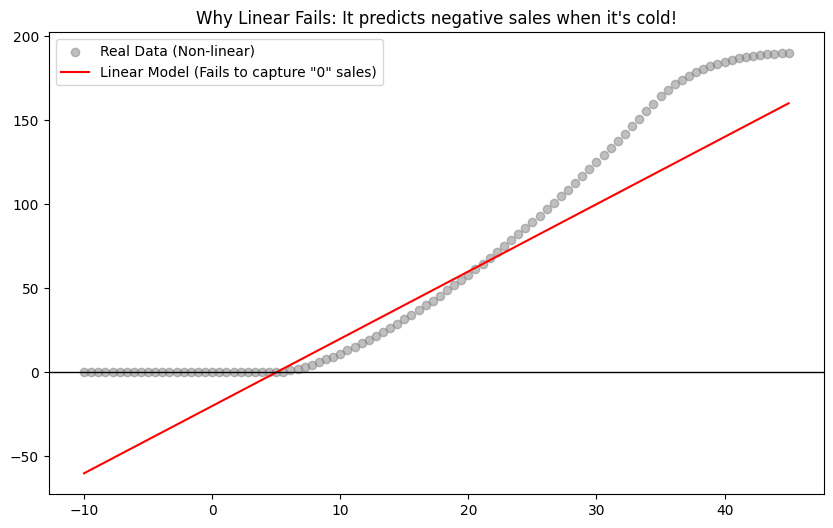

In [19]:
# 使用经典ReLU (Rectified Linear Unit) 激活函数来做实验。
# 它的数学定义非常简单：$f(x) = \max(0, x)$。也就是“负数全变 0，正数照常通过

import numpy as np
import matplotlib.pyplot as plt

# 1. 模拟现实数据：气温与冰淇淋销量
temp = np.linspace(-10, 45, 100)
# 真实的销售规律（带有2个拐点的曲线）
real_sales = np.where(temp < 5, 0, (temp - 5)**1.5)
real_sales = np.where(temp < 35, real_sales, real_sales - 2 * (temp - 35)**1.5)

# 2. 模拟一个“纯线性”神经元 (y = wx + b)
# 无论你怎么调整 w 和 b，它只能是一条直线
w, b = 4, -20
linear_model = w * temp + b

plt.figure(figsize=(10, 6))
plt.scatter(temp, real_sales, color='gray', alpha=0.5, label='Real Data (Non-linear)')
plt.plot(temp, linear_model, 'r', label='Linear Model (Fails to capture "0" sales)')
plt.axhline(0, color='black', lw=1)
plt.title("Why Linear Fails: It predicts negative sales when it's cold!")
plt.legend()
plt.show()

如上图所示：目前我们有一个典型的非线性问题：“根据【气温】预测【冰淇淋销量】”
它的逻辑不是一条直线，而是有拐点的：
1. 太冷时：气温从 $-10^{\circ}\text{C}$ 升到 $0^{\circ}\text{C}$，销量几乎都是 0（没人吃）。
2. 舒适时：气温从 $10^{\circ}\text{C}$ 升到 $25^{\circ}\text{C}$，销量开始稳步增长。
3. 酷热时：气温超过 $35^{\circ}\text{C}$，大家可能都不愿出门，或者销量达到机器产能极限，增长放缓。

但是如果我们使用线性模型去拟合，你会发现，销量出现了负数，这实际上是不可能发生的，而且销量和温度也不可能出现线性增长。

如果我们给这个线性函数（在神经网络中称之为神经元）加一个 ReLU 激活函数 $\max(0, wx+b)$，神奇的事情发生了：它拥有了“截断”的能力

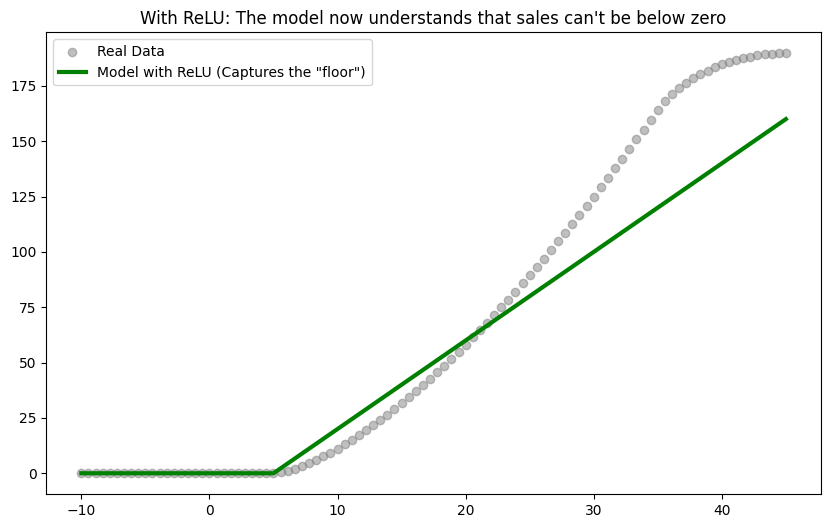

In [20]:
# 3. 模拟带 ReLU 的神经元
# 当 wx+b < 0 时，输出强制为 0
relu_model = np.maximum(0, w * temp + b)

plt.figure(figsize=(10, 6))
plt.scatter(temp, real_sales, color='gray', alpha=0.5, label='Real Data')
plt.plot(temp, relu_model, 'g', linewidth=3, label='Model with ReLU (Captures the "floor")')
plt.title("With ReLU: The model now understands that sales can't be below zero")
plt.legend()
plt.show()

通过 ReLU，模型学会了在 $10^{\circ}\text{C}$ 左右这个点“拐弯”。这个拐点就是非线性表达能力的开始。
一个激活函数对一个笔直的线性关系做了弯折，出现了一个拐点，接着我们又想，到了35度以后，销量又会放缓，是不是可以引入更多的拐点呢？

这其实是很自然的想法，也是多神经元的由来。当我们引入一个线性关系+一个激活函数的时候，一个局部特征被我们捕捉到了，在上述案例里，我们选择让小于0的不通过，就是一种局部特征的捕捉，这种类似于分段式的线性表达，通过激活函数可以结合到一起。

tips：这一思想的本质就是通用近似定理 (Universal Approximation Theorem)，还记得在微积分里，把曲线看作无数段极短的直线。如果把一个曲线分成超级小的一段一段，那每一段都是线性的，激活函数就是用来切割每一段的工具。

比如自然界中有许多的现象都遵从sin函数的变换，假设我们不知道sin函数的求解，我们完全可以通过一段一段的直线+制造拐点来模拟逼近。这一过程事实上就是神经网络做的事情。


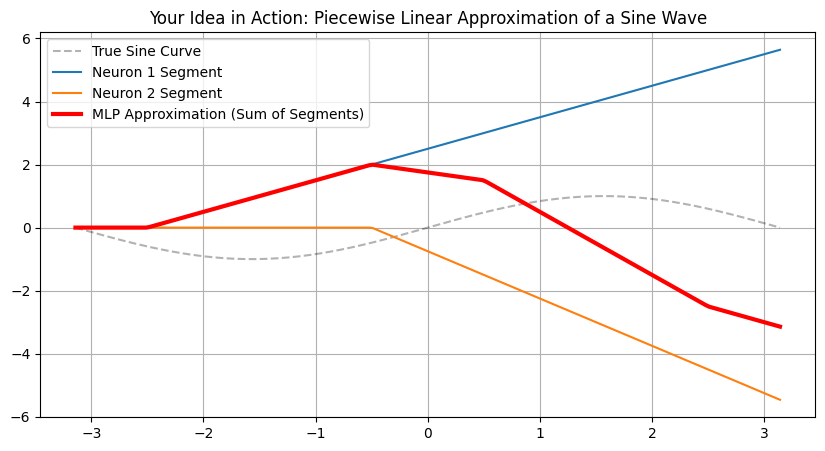

In [21]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-np.pi, np.pi, 200)
y_true = np.sin(x)

# 模拟 4 个 ReLU 神经元，每个负责一段
# 这里的参数是我手动凑的，模拟网络学习到的权重
n1 = 1.0 * np.maximum(0, x + 2.5)  # 第一段折线
n2 = -1.5 * np.maximum(0, x + 0.5) # 第二段，用来往下压
n3 = -1.5 * np.maximum(0, x - 0.5) # 第三段，继续往下压
n4 = 1.0 * np.maximum(0, x - 2.5)  # 最后一段，往回拉

# 叠加结果
y_pred = n1 + n2 + n3 + n4

plt.figure(figsize=(10, 5))
plt.plot(x, y_true, 'k--', label='True Sine Curve', alpha=0.3)
plt.plot(x, n1, label='Neuron 1 Segment')
plt.plot(x, n2, label='Neuron 2 Segment')
plt.plot(x, y_pred, 'r', linewidth=3, label='MLP Approximation (Sum of Segments)')
plt.title("Your Idea in Action: Piecewise Linear Approximation of a Sine Wave")
plt.legend()
plt.grid(True)
plt.show()

### 2.2 多个神经元
上文我们聊过了在上文聊了关于激活函数如何捕捉非线性关系的，接下来我们就沿着我们的想法->制造多个拐点，再来讨论这些拐点在神经网络中的位置。不过在此之前，我们需要回顾下神经元的概念。

已知：人工神经元是感知机（Perceptron）的基本单元，它接收多个输入信号，通过加权求和并加上偏置，结构如下：
```python
        ------------------------
输入层     x1      x2      x3
神经元1  ------------------------
           │       │       │
         w1│     w2│     w3│
           ▼       ▼       ▼
        -------------------------
        |   加权求和：z = w·x + b |
        -------------------------
输出层            输出 Z
```

在我们上文通过激活函数后，结构变化成了：
```PYTHON
        ------------------------
输入层     x1      x2      x3
神经元1  ------------------------
           │       │       │
         w1│     w2│     w3│
           ▼       ▼       ▼
        -------------------------
        |   加权求和：z = w·x + b |
        -------------------------
                  输出 z
                     │
                     ▼
        -------------------------
        |   激活函数：a = ReLU(z) |
        -------------------------
                     │
                     ▼
输出层          输出a
```
现在我们就有了一个1个神经元的，带1个激活函数的神经网络；在冰淇淋的案例里，我们通过引入激活函数制造了拐点，现在我们想要对线段的多个地方制造拐点，应该做的事情是：
- 神经元 1 (苏醒于 5度)：负责让销量从 5 度开始往上冲.温度为5以下的时候，输出销量为0
- 神经元 2 (苏醒于 35度)：它的权重 $w$ 是负数。当温度超过 35 度时，它开始产生一个越来越大的负值
结构如下：

```PYTHON
------------------ 输入层 (Input) ------------------
                      气温 x
            /                       \
           /                         \
    权重 w1, 偏置 b1          权重 w2, 偏置 b2
         /                             \
------------------ 隐藏层 (Hidden) ------------------
|  神经元 1 (5度专家)   |       |  神经元 2 (35度专家)  |
|  z1 = w1·x + b1      |       |  z2 = w2·x + b2      |
|  a1 = ReLU(z1)       |       |  a2 = ReLU(z2)       |
----------------------------------------------------
           \                         /
            \                       /
          权重 W_out1             权重 W_out2
              \                   /
------------------ 输出层 (Output) ------------------
          加权求和: 销量 y = a1·W_out1 + a2·W_out2
```





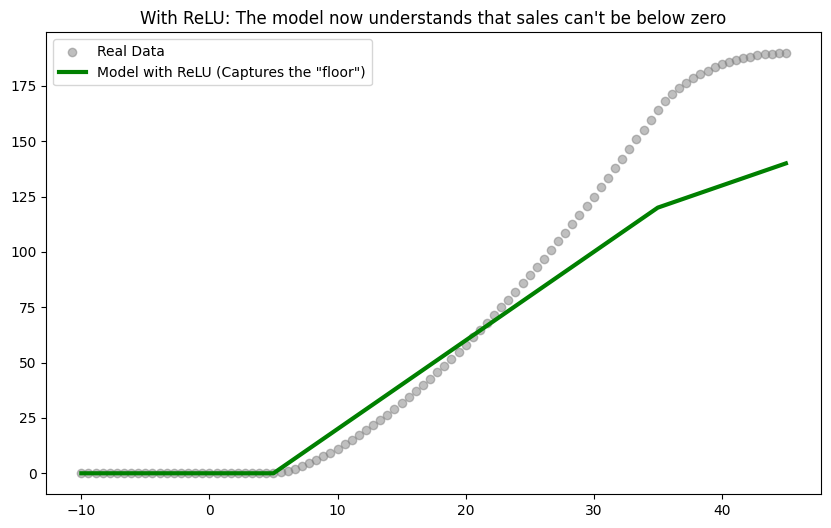

In [33]:
# 4. 模拟带 ReLU 的神经元
# 当 wx+b < 0 时，输出强制为 0
relu_model = np.maximum(0, w * temp + b)
# 当气温过大于35时，销量放缓，我们可以再加一个ReLU来模拟这个拐点
relu_model = np.where(temp > 35, relu_model - 2 * (temp - 35), relu_model)

plt.figure(figsize=(10, 6))
plt.scatter(temp, real_sales, color='gray', alpha=0.5, label='Real Data')
plt.plot(temp, relu_model, 'g', linewidth=3, label='Model with ReLU (Captures the "floor")')
plt.title("With ReLU: The model now understands that sales can't be below zero")
plt.legend()
plt.show()

## 2.2 隐藏层


**输入层和输出层之间的一切层，都叫隐藏层。隐藏层越多（深度学习），模型就能推导出越高级、越抽象的概念**
- 想象你在面试一个人，看到的简历就是输入层，即最初的样本
- 隐藏层就是你大脑里的中间推论。你不会直接从“工作 5 年”跳到“录用”，你中间会想：“这人经验丰富”、“可能对薪资要求高”、“稳定性或许一般”。这些“经验丰富”、“稳定性”就是隐藏特征
- 隐藏层一般从第一个线性变换开始，顺序通常是：
  - 输入 $\rightarrow$ [线性变换 $\rightarrow$ 激活函数] $\rightarrow$ [线性变换 $\rightarrow$ 激活函数] $\rightarrow$ 输出
- 一次线性变换+一次激活，称之为一个计算层


计数规则：
   1. 输入层不计数：当我们说“这是一个 3 层感知机”时，通常指 2 个隐藏层 + 1 个输出层。输入层只是数据的入口，没有计算参数（$W$ 和 $b$），所以不计入层数。
   2. 输出层（Output Layer）：输出层也包含一次线性变换，但是否包含激活函数取决于你的任务（分类任务通常有 Softmax，回归任务可能直接输出线性结果）


## 2.2 MLP构建

## 2.3 MLP的训练过程⭐

## 前向传播

### 损失计算

# 计算图

## 参数更新

| 步骤    | 输入            | 核心动作        | 产出             |
| ----- | ------------- | ----------- | -------------- |
| 1. 前向 | 数据 + 参数       | 矩阵运算 + 激活函数 | 预测结果           |
| 2. 损失 | 预测结果 + 真值     | 计算误差函数      | Loss值          |
| 3. 反向 | Loss值 + 链式法则  | 求导（找责任）     | 梯度 (Gradient)  |
| 4. 更新 | 参数 + 梯度 + 学习率 | 梯度下降（减法）    | 新参数 (New w, b) |


## 附录内容
### 其他优化算法（近似最小损失函数）

- **Adam 优化器**  
目前 90% 以上的大模型（如 GPT 系列、Llama、DeepSeek）训练时都采用 Adam（Adaptive Moment Estimation）。它为梯度下降增加了两个“buff”：

    - **动量（Momentum）**：不仅考虑当前的梯度，还参考之前的惯性。直观理解：如果之前一直往南走，现在的坡度也向南，就加速冲下去；如果坡度突然变化，也不会立刻掉头，而是受惯性影响平滑转弯。这有助于跨越一些微小的“局部最小值”。
    - **自适应学习率（Adaptive Learning Rate）**：为每个参数（如几千亿个 $w$）配备独立的“变速箱”。直观理解：更新频繁、梯度大的参数，学习率调小，避免步子太大；更新慢、梯度小的参数，学习率调大，提高效率。

这些优化算法让模型训练更加高效、稳定。